In [1]:
#Copyright 2018, Seokjun Bu, Softcomputing LAB all rights reserved.
from keras import backend as K
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution3D, MaxPooling3D, AveragePooling3D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.convolutional import Conv2DTranspose
from keras.layers import UpSampling2D
from keras.layers import LSTM, TimeDistributed, CuDNNLSTM
from keras.layers import Input, BatchNormalization
from keras.layers import Input
from keras.models import Model
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import itertools
%matplotlib inline

Using TensorFlow backend.


In [2]:
X_test = np.load('../dataset/test/X_test.npy')
X_train = np.load('../dataset/test/X_train.npy')

Y_test = np.load('../dataset/test/Y_test.npy')
Y_train = np.load('../dataset/test/Y_train.npy')

print(X_test.shape, X_train.shape)
print(Y_test.shape, Y_train.shape)

(1000, 64, 64, 3) (3000, 64, 64, 3)
(1000, 3) (3000, 3)


In [3]:
class_list = ['Young' 'Middle' 'Old']



In [15]:
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = BatchNormalization()(model_hidden)
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Dropout(0.5)(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(512, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)



In [16]:
model_cnn = Model(model_input, model_output)
model_cnn.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 16)        1040      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 16)        0         
__________

In [17]:
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


In [18]:
# Train
es = EarlyStopping(mode='auto', monitor='val_loss', patience=4)
model_history = model_cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=512, verbose=2, shuffle=True, callbacks=[es])


Train on 3000 samples, validate on 1000 samples
Epoch 1/10
 - 19s - loss: 6.3827 - acc: 0.4257 - val_loss: 7.0769 - val_acc: 0.5170
Epoch 2/10
 - 14s - loss: 6.8522 - acc: 0.4380 - val_loss: 6.4096 - val_acc: 0.4880
Epoch 3/10
 - 15s - loss: 6.5241 - acc: 0.5087 - val_loss: 6.3826 - val_acc: 0.5170
Epoch 4/10
 - 14s - loss: 6.4244 - acc: 0.4790 - val_loss: 6.3827 - val_acc: 0.5170
Epoch 5/10
 - 14s - loss: 6.3155 - acc: 0.5077 - val_loss: 5.8530 - val_acc: 0.5200
Epoch 6/10
 - 15s - loss: 4.4998 - acc: 0.5203 - val_loss: 1.0241 - val_acc: 0.4970
Epoch 7/10
 - 14s - loss: 1.1080 - acc: 0.4147 - val_loss: 1.1628 - val_acc: 0.3800
Epoch 8/10
 - 14s - loss: 0.9856 - acc: 0.5057 - val_loss: 0.9303 - val_acc: 0.5780
Epoch 9/10
 - 14s - loss: 0.9292 - acc: 0.5703 - val_loss: 0.9304 - val_acc: 0.5030
Epoch 10/10
 - 14s - loss: 0.9093 - acc: 0.5853 - val_loss: 0.9019 - val_acc: 0.5840


In [9]:
# Handcrafted Function Def.
def wrapped_confusion_matrix(modelInput, feature, label, class_list=["first", "second"], normalize=False, fig_size=(5,5)):
    pred = modelInput.predict(feature)
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(pred, axis=1))
    np.set_printoptions(precision=2)
    plt.figure(figsize=fig_size) 
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(len(class_list)), class_list, rotation=45)
    plt.yticks(np.arange(len(class_list)), class_list)
    if(normalize):
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
def plot_history(model_input, mode='loss', val_mode=True, title='Entropy'):
    history = model_input.history
    if(val_mode):
        plt.plot(history.history[mode])
        plt.plot(history.history['val_'+mode])
        plt.title(title)
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()
    else:
        plt.plot(history.history[mode])
        plt.title(title)
        plt.legend(['train'], loc='upper right')
        plt.show()

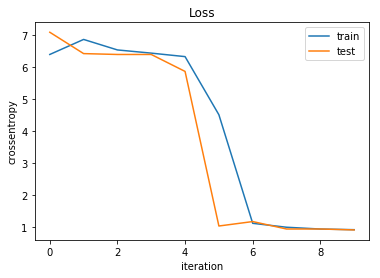

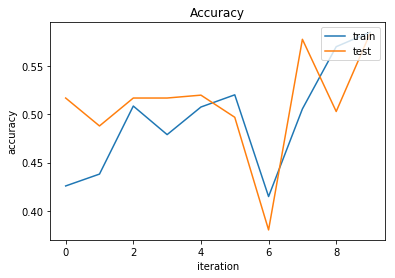

In [19]:
# Validation: Curve Plotting
# Loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('crossentropy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# Accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 16)        1040      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 16)        0         
__________

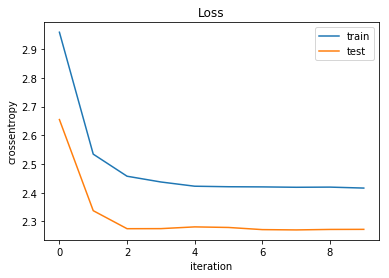

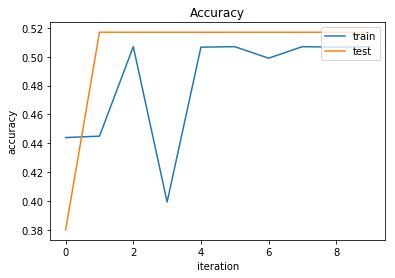

In [22]:
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='sigmoid')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = BatchNormalization()(model_hidden)
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='sigmoid')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Dropout(0.5)(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(512, activation='tanh')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)

model_cnn = Model(model_input, model_output)
model_cnn.summary()
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# Train
es = EarlyStopping(mode='auto', monitor='val_loss', patience=4)
model_history = model_cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=512, verbose=2, shuffle=True, callbacks=[es])

# Validation: Curve Plotting
# Loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('crossentropy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# Accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 16)        1040      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 16)        0         
__________

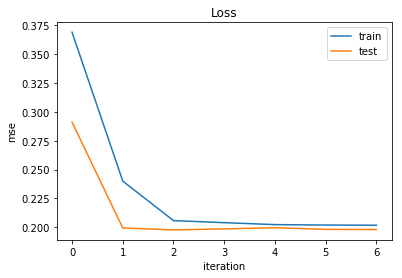

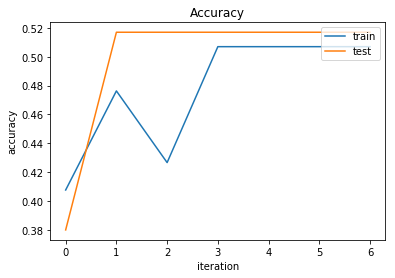

In [23]:
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='sigmoid')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = BatchNormalization()(model_hidden)
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='sigmoid')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Dropout(0.5)(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(512, activation='sigmoid')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)

model_cnn = Model(model_input, model_output)
model_cnn.summary()
model_cnn.compile(loss='mse', optimizer='adam', metrics=['acc'])
# Train
es = EarlyStopping(mode='auto', monitor='val_loss', patience=4)
model_history = model_cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=512, verbose=2, shuffle=True, callbacks=[es])

# Validation: Curve Plotting
# Loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('mse')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# Accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 16)        1040      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 16)        0         
__________

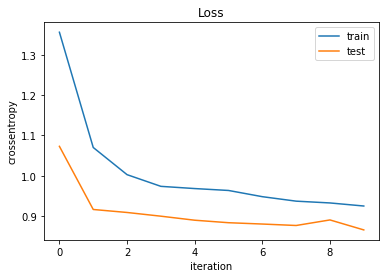

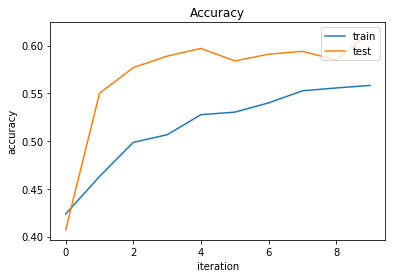

In [24]:
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = BatchNormalization()(model_hidden)
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Dropout(0.5)(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(512, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)

model_cnn = Model(model_input, model_output)
model_cnn.summary()
model_cnn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
# Train
es = EarlyStopping(mode='auto', monitor='val_loss', patience=4)
model_history = model_cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=512, verbose=2, shuffle=True, callbacks=[es])

# Validation: Curve Plotting
# Loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('crossentropy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# Accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 16)        1040      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 16)        0         
__________

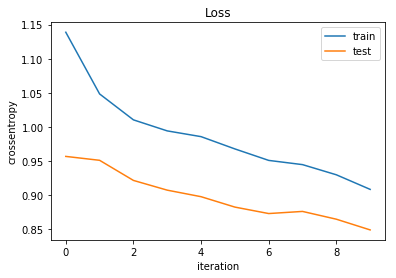

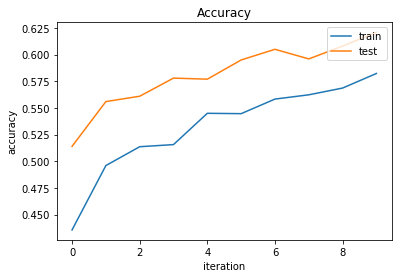

In [25]:
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='tanh')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = BatchNormalization()(model_hidden)
model_hidden = Convolution2D(16, kernel_size=(2, 2), padding='same', activation='tanh')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Dropout(0.5)(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(512, activation='tanh')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)

model_cnn = Model(model_input, model_output)
model_cnn.summary()
model_cnn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
# Train
es = EarlyStopping(mode='auto', monitor='val_loss', patience=4)
model_history = model_cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=512, verbose=2, shuffle=True, callbacks=[es])

# Validation: Curve Plotting
# Loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('crossentropy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# Accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
